## Calculating $\Omega_m,\Omega_{\Lambda},\Omega_{k}$ with MCMC Walkers
When we observe other galaxies, we can see that their light is redshifted. This is due to expansion of the universe, because as the universe expands, the light waves get stretched. The rate at which the universe is expanding is called the hubble constant, $H_0$. But if we assume the hubble constant is constant, our model for predicting the redshift of galaxies becomes incredibly inaccurate when looking at far away galaxies. 
  
This is because the rate at which the universe is expanding is not constant and is actually accelerating. There are three variables that determine the rate at which the universe is expanding: $\Omega_m$(the contribution of matter both dark and light), $\Omega_{\Lambda}$(the contribution of dark energy), and $\Omega_{k}$(the contribution of the curvature of the universe). 
  
Within this project we are going to use MCMC walkers to calculate the values of these three variables.

The data we have measures the distance modulus of a galaxy and to work with this we need to convert it into distance in parsecs. The equation for distance modulus is $\mu (\text{distance modulus}) = m - M = 5 \log_{10} \left( {d_{\text{pc}}} \right) - 5$. So in order to rewrite this equation in terms of $d_{\text{pc}}$ we get the equation: ${d_{\text{pc}}} = 10^{((\mu+5)/5)}$

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
from scipy.integrate import quad

#The function that converts distance modulus to distance in parsecs
def compute_distance_pc(distance_modulus):
    return 10 ** ((distance_modulus + 5) / 5)
data = pd.read_csv('Hubble.csv')
data['Shoes_Distance_pc'] = compute_distance_pc(data['MU_SH0ES'])

#renames the columns into a more convient form
data['zHD_redshift'] = data['zHD']
data['zHD_redshift_error'] = data['zHDERR']


For the first part of this project we are only going to be looking at galaxies within 100 megaparsecs. So we create a filtered data set to work with. 

In [14]:
#This grabs only the data that is close to the earth
Close_data = data.loc[data['Shoes_Distance_pc'] < (100 * 1e6)]

Now we create our model that are MCMC walkers are going to crawl. It will be the hubble relation which is $cz=H_0d$, where $c$ is the speed of light, $z$ is the redshift, $H_0$ is the hubble constant, and $d$ is the distance in parsecs. 
  
We define the likelyhood, pdf and prior functions simmalarly to how we did in the MCMC Dark Matter Estimates projects, so if you want a more detailed explanation of how they work, you can look there. 

In [15]:
def velocity(hubble, distance_pc):
    return hubble * (distance_pc * 1e-6) # pc to Mpc

def ln_prior(hubble):
    if 0 < hubble:
        return 0
    return -np.inf

def ln_likelihood(hubble, distance_data, velocity_data_km_s, velocity_data_error):
    velocity_model_predicted = velocity(hubble, distance_data)
    return -0.5 * np.sum(((velocity_data_km_s - velocity_model_predicted) / velocity_data_error) ** 2)

def ln_pdf(params, distance_data, velocity_data_km_s, velocity_data_error):
    hubble = params
    p = ln_prior(hubble)
    if p == -np.inf:
        return -np.inf
    return p + ln_likelihood(hubble, distance_data, velocity_data_km_s, velocity_data_error)

Now we have the walkers crawl the model with the hubble constant as the parameter. We have it randomly start around 70 for efficency of the burn in period. We clean the data a little before passing ti to the walkers multiplying the redshift by 3e5 to get the redshift, and redshift error in meters per second.

In [16]:
nwalkers = 10  # or 40
ndim = 1
nsteps = 3000
initial_positions = 70+np.random.rand(nwalkers, ndim)  # Random initial positions for the walkers

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pdf, args=(Close_data['Shoes_Distance_pc'], Close_data['zHD_redshift'] * 3e5, Close_data['zHD_redshift_error'] * 3e5)) # multiplying by 3e5 turns into velocity

sampler.run_mcmc(initial_positions, nsteps)

# Get the chain of samples
samples = sampler.get_chain()

Next we plot the walkers hubble constants throughout their steps. Luckily we see the walkers converge, which is a good indicator that our model is working. 

Text(0.5, 1.0, 'Hubble Constant MCMC')

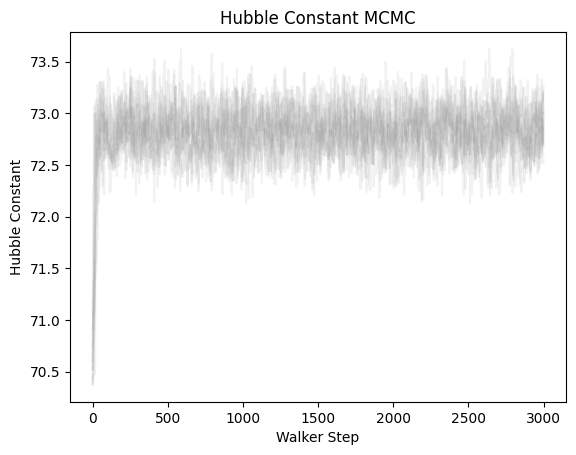

In [17]:
plt.plot(samples[:, :, 0], color='gray', alpha=0.1)
plt.xlabel('Walker Step')
plt.ylabel('Hubble Constant')
plt.title('Hubble Constant MCMC')

Now we examine the walkers hubble constant with the burn in removed. We can see the hubble constant is somewhere between 72.4 and 73.4 km/s/Mpc. 

Text(0.5, 1.0, 'Hubble Constant MCMC (Burn-in removed)')

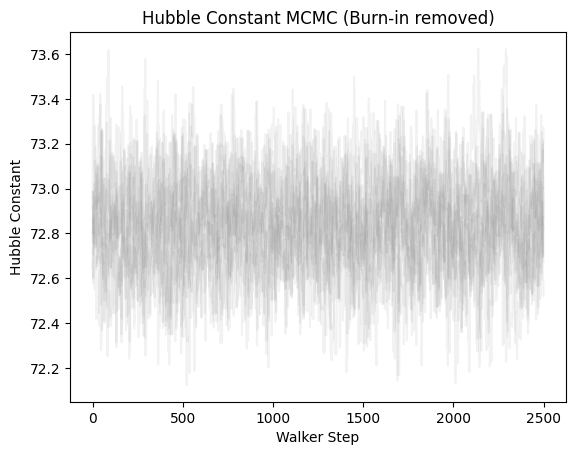

In [18]:
samples = samples[500:, :, :]
plt.plot(samples[:, :, 0], color='gray', alpha=0.1)
plt.xlabel('Walker Step')
plt.ylabel('Hubble Constant')
plt.title('Hubble Constant MCMC (Burn-in removed)')

We then take the median average of the hubble constants and use it within our data. When then plot what our model predicted and the velocities of the data. We can see that our model is very accurate, with the actual data lying incredibly close to the model. Note that this in only within 100 megaparsecs.

Text(0.5, 1.0, 'Hubble Constant')

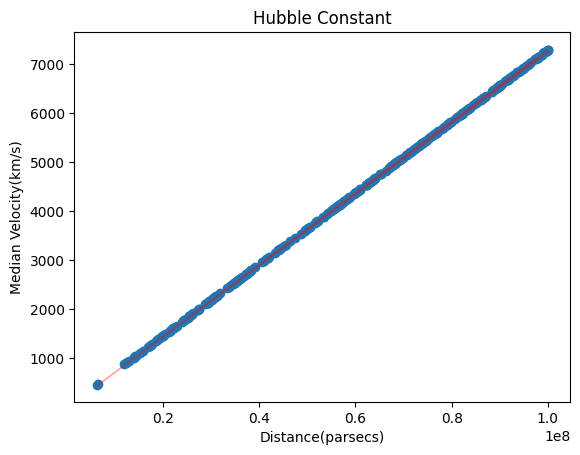

In [19]:
samples = samples.flatten()


# Calculate velocities for each resampled pair of distance and redshift
hubbles = []
for i in range(100):
    idx = np.random.randint(len(samples))
    hubble = samples[idx]
    
    hubbles.append(velocity(Close_data['Shoes_Distance_pc'], hubble))

# Plot
hubbles= np.array(hubbles)
median = np.median(hubbles, axis=0)
std = np.std(hubbles, axis=0)
plt.scatter(Close_data['Shoes_Distance_pc'], median)
plt.xlabel('Distance(parsecs)')
plt.ylabel('Median Velocity(km/s)')
plt.fill_between(Close_data['Shoes_Distance_pc'], median - std, median +std, color='r', alpha=0.3)
plt.title('Hubble Constant')

Now we are gonna look at the hubble constant across the entire data set. Notice how the further away the galaxy is the less accurate our model is. This can be explained by the fact that the hubble constant has changed over time. 

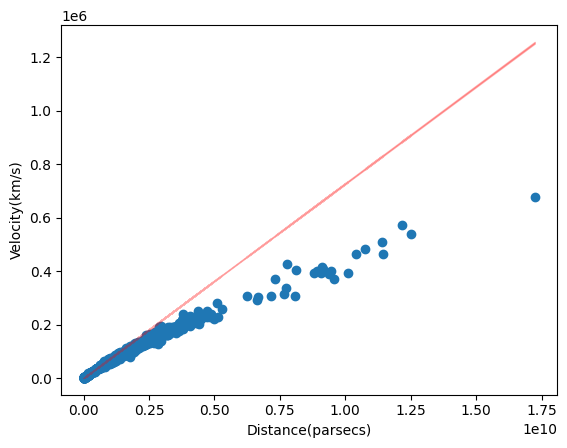

In [20]:
# Calculate velocities for each resampled pair of distance and redshift
hubbles = []
for i in range(100):
    idx = np.random.randint(len(samples))
    hubble = samples[idx]
    
    hubbles.append(velocity(data['Shoes_Distance_pc'], hubble))

# Plot
hubbles= np.array(hubbles)
median = np.median(hubbles, axis=0)
std = np.std(hubbles, axis=0)
plt.scatter(data['Shoes_Distance_pc'], data['zHD_redshift'] * 3e5)
plt.xlabel('Distance(parsecs)')
plt.ylabel('Velocity(km/s)')
plt.fill_between(data['Shoes_Distance_pc'], median - std, median + std, color='r', alpha=0.3)

Now we are going to use a different model for our walkers to crawl. This model accounts for the fact that the hubble constant has changed over time. It has four parameters $H_0$, $\Omega_m$, $\Omega_{\Lambda}$, and $\Omega_{k}$. $H_0$ is still the current hubble constant, $\Omega_m$ is the matter density, $\Omega_{\Lambda}$ is the dark energy density, and $\Omega_{k}$ is the curvature density. The formula for $H(z)$ the amount of redshift is modeled below. 

$d=(1+z)c\int_{0}^{z}\frac{dz}{H(z')} dz'$
     
$H(z) = H_0 \sqrt{\Omega_m(1+z)^3 + \Omega_{\Lambda}}+\Omega_{k}(1+z)^2$

In [21]:
def H_z(z, H0, Omega_M, Omega_k, Omega_Lambda):
    return H0 * np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

def distance_speed_relation(z, H0, Omega_M, Omega_k, Omega_Lambda):
    c = 3e5
    lst = []

    integrand = lambda z: 1 / H_z(z, H0, Omega_M, Omega_k, Omega_Lambda)
    for z1 in z:
        integral, _ = quad(integrand, 0, z1)
        lst.append((1 + z1) * c * integral)
    return lst

Now we need to tweak our prior and likelyhood function to account for the new model. We add parameters of $\Omega_m$, $\Omega_{\Lambda}$, and $\Omega_{k}$ to the likelyhood function. Also we need to add a few conditions to the prior function, namely $.95<\Omega_m + \Omega_{\Lambda} + \Omega_{k}<1.05$ because we want all the omegas to add up to around 1. Additionally we need to make sure that none of the omegas become negative values so we add the condition that $\Omega_m > 0$ and $\Omega_{\Lambda} > 0$ and $\Omega_{k} > 0$.

In [22]:
def ln_prior(params):
    H0, Omega_M, Omega_k, Omega_Lambda = params
    if H0 > 0 and Omega_M > 0 and Omega_k > 0 and Omega_Lambda > 0 and (Omega_M + Omega_k + Omega_Lambda) > 0.95 and (Omega_M + Omega_k + Omega_Lambda) < 1.05:
        return 0
    return -np.inf

def ln_likelihood(params, distance_data, zHD, zHDERR):
    H0, Omega_M, Omega_k, Omega_Lambda = params
    
    distance_predicted = distance_speed_relation(zHD, H0, Omega_M, Omega_k, Omega_Lambda)
    
    return -0.5 * np.sum((distance_data - distance_predicted) ** 2 / zHDERR**2)

def ln_pdf(params, distance_data, zHD, zHDERR):
    p = ln_prior(params)
    if p == -np.inf:
        return -np.inf
    return p + ln_likelihood(params, distance_data, zHD, zHDERR)

Now we have set everything up we can have the walkers crawl the model. We have the walkers start at random values around 70, 0.29, 0.01, and 0.71. We then run ten walkers for around 3000 steps

In [25]:
nwalkers = 10
ndim = 4
nsteps = 3000
initial_positions = np.random.multivariate_normal([73, 0.29, 0.01, 0.71], np.diag([1, 0.001, 0.001, 0.001]), nwalkers) 

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pdf, args=(data['Shoes_Distance_pc']/1E6, data['zHD_redshift'], data['zHD_redshift_error']))

sampler.run_mcmc(initial_positions, nsteps)

# Get the chain of samples
samples = sampler.get_chain()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Now we remove the burn in period and plot the walkers values. We can see that the walkers have converged and this shows us the range of possible values of the omegas 

Text(0, 0.5, 'Omega_Lambda')

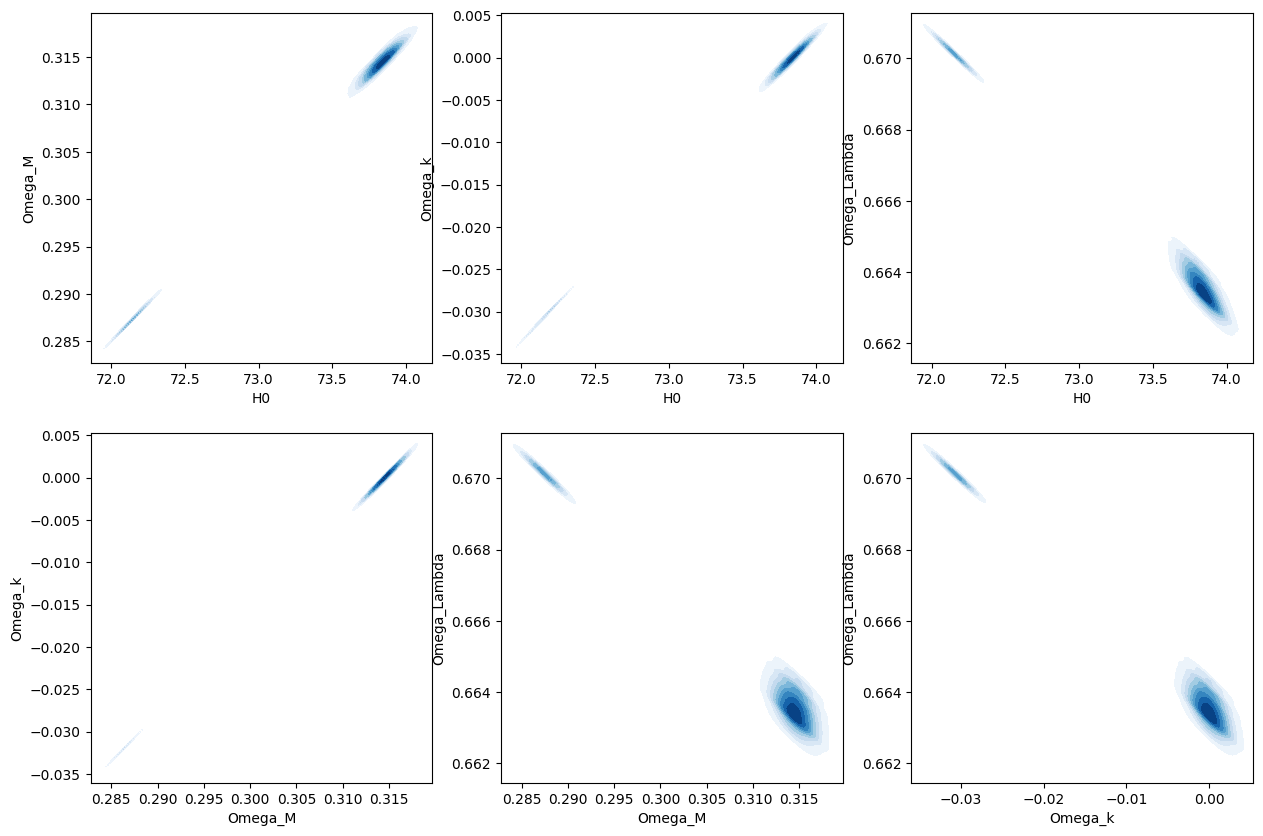

In [ ]:
samples = samples[1000:, :, :]

samples_H0 = samples[:, :, 0].flatten()
samples_Omega_M = samples[:, :, 1].flatten()
samples_Omega_k = samples[:, :, 2].flatten()
samples_Omega_Lambda = samples[:, :, 3].flatten()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.kdeplot(x=samples_H0, y=samples_Omega_M, ax=axs[0, 0], cmap='Blues', fill=True)
axs[0, 0].set_xlabel('H0')
axs[0, 0].set_ylabel('Omega_M')
sns.kdeplot(x=samples_H0, y=samples_Omega_k, ax=axs[0, 1], cmap='Blues', fill=True)
axs[0, 1].set_xlabel('H0')
axs[0, 1].set_ylabel('Omega_k')
sns.kdeplot(x=samples_H0, y=samples_Omega_Lambda, ax=axs[0, 2], cmap='Blues', fill=True)
axs[0, 2].set_xlabel('H0')
axs[0, 2].set_ylabel('Omega_Lambda')
sns.kdeplot(x=samples_Omega_M, y=samples_Omega_k, ax=axs[1, 0], cmap='Blues', fill=True)
axs[1, 0].set_xlabel('Omega_M')
axs[1, 0].set_ylabel('Omega_k')
sns.kdeplot(x=samples_Omega_M, y=samples_Omega_Lambda, ax=axs[1, 1], cmap='Blues', fill=True)
axs[1, 1].set_xlabel('Omega_M')
axs[1, 1].set_ylabel('Omega_Lambda')
sns.kdeplot(x=samples_Omega_k, y=samples_Omega_Lambda, ax=axs[1, 2], cmap='Blues', fill=True)
axs[1, 2].set_xlabel('Omega_k')
axs[1, 2].set_ylabel('Omega_Lambda')


Now using the median values for the parameters(Hubble constant, $\Omega_m$, $\Omega_{\Lambda}$, $\Omega_{k}$) and graph a new model using this. We fill in the 1 $\sigma$ range for the model as well. We can notice by seeing how the points lie near the model that our model is working well. Additionally the 1 $\sigma$ range is extremely small, you can't see it on the graph but the stand devation is around 1.08e-11. Overall we can see that our new model and parameter values is working way better than our previous model.
  
We now use the median values for the parameters($H_0$, $\Omega_m$, $\Omega_{\Lambda}$, $\Omega_{k}$) and graph the expected values of this model. Next we graph the actual values within the data set. We can see that this model is way more accurate than the previous model at further ranges. This implies that the new model is more accurate than the previous model. 

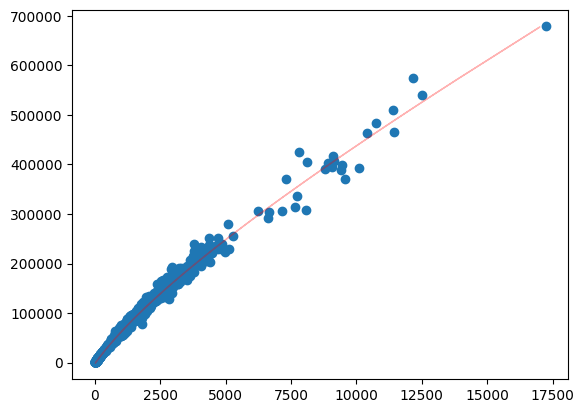

In [ ]:
median_H0 = np.median(samples_H0)
median_Omega_M = np.median(samples_Omega_M)
median_Omega_k = np.median(samples_Omega_k)
median_Omega_Lambda = np.median(samples_Omega_Lambda)

distances = []
for i in range(100):
    distances.append(distance_speed_relation(data['zHD_redshift'], median_H0, median_Omega_M, median_Omega_k, median_Omega_Lambda))

distances = np.array(distances)

median = np.median(distances, axis=0)
std = np.std(distances, axis=0)

plt.scatter(data['Shoes_Distance_pc'] * 1e-6, data['zHD_redshift'] * 3e5)
plt.fill_betweenx(data['zHD_redshift'] * 3e5, median - std, median + std, color='r', alpha=0.3)

Finally we are going to examine the actual median values of all the parameters. We can see that the hubble constant is around 73.6 km/s/Mpc, $\Omega_m$ is around 0.32, $\Omega_{\Lambda}$ is around 0.67, and $\Omega_{k}$ is incredibly close to zero. This aligns nicely with what other scientists have found. 

In [ ]:
print('Hubble Constant Estimated Value: '+median_H0)
print('Omega_M Estimated Value: '+median_Omega_M)
print('Omega_k Estimated Value: '+median_Omega_k)
print('Omega_Lambda Estimated Value: '+median_Omega_Lambda)

(73.57592373636312,
 0.3167161042323662,
 1.497069410724779e-07,
 0.6683002305092862)